# Binary Classification

## Introduction
In the realm of machine learning, binary classification stands as a fundamental task where models discern between two categories based on input data. This notebook explores the utilization of a pretrained backbone, specifically ResNet, to perform binary classification tasks efficiently. Pretrained models offer the advantage of leveraging previously learned features on large datasets, enabling quick adaptation to specific, smaller tasks with minimal training data.

ResNet, known for its deep architecture and residual learning framework, is particularly adept at capturing intricate patterns in image data, making it an excellent choice for tasks that require high levels of visual discrimination. This approach not only accelerates the model training process but also significantly improves performance, especially when training data is limited.

Furthermore, this notebook introduces an innovative alternative method: the cut-out technique. Unlike traditional sliding window techniques, which systematically select windows for analysis, the cut-out method strategically excises errors, providing training samples where defects are centered. This targeted approach ensures that the model consistently learns from the most critical features of the data, enhancing its ability to accurately classify new instances.


In [1]:
import json
import random
import os
import shutil
from sahi.slicing import slice_coco
from torch import nn
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import glob
from sahi.slicing import slice_image
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader
from tqdm import tqdm

## Configurable variables

In [2]:
# Dataset path
dataset_directory = "../dataset/binary_window/full_bg_fault"
validate_test_directory = "../dataset/binary_window/full_bg_fault"
classes = ('bg', 'faults')
model_directory = "final_models" #directory where models are saved

# Training configuration
size = 224
batch_size = 32
learning_rate = 0.001
epochs = 20
model_name = "resnet50"

#Enable CUDA for a faster training proces
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



## Dataloaders

The dataset loading process involves two key operations:

1. **Transformations**: The data is normalized and converted into Tensor format, which is required by the Convolutional Neural Network (CNN).
   
2. **Handling Imbalanced Dataset**: The imbalanced nature of the training dataset is addressed using the weighted random sampler.

These steps ensure that the data is in the correct format for the CNN and that the training process is not biased by class imbalances.

In [ ]:
# Tensor transform
# Normalisation parameters
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]) 

transform = {
'train': transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    normalize,

]),
'validate': transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    normalize, 
]),
'test': transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    normalize, 
]),
}

# Datasets
training_dataset = datasets.ImageFolder(dataset_directory+"/train", transform=transform['train'])
validation_dataset = datasets.ImageFolder(validate_test_directory+"/validate", transform=transform['validate'])
test_dataset = datasets.ImageFolder(validate_test_directory+"/test", transform=transform['test'])
datasets_dict = {'train': training_dataset, 'valid': validation_dataset, 'test': test_dataset}

# Use torch.unique to get the count of images per class
class_labels, class_counts = torch.unique(torch.tensor(training_dataset.targets), return_counts=True)

# Calculate class weights for sampler
class_weights = 1. / class_counts.float()
# List with weight value per sample (same length as dataset)
sample_weights = class_weights[training_dataset.targets]

# Create a WeightedRandomSampler
sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = torch.utils.data.DataLoader(datasets_dict['train'], batch_size=batch_size, sampler=sampler)
valid_loader = torch.utils.data.DataLoader(datasets_dict['valid'], batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets_dict['test'], batch_size=batch_size, shuffle=True)
dataloaders_dict = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

## CNN training

The CNN is trained with the ResNet50 pretrained backbone. All layers are finetuned.

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Is CUDA supported by this system? True
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(6

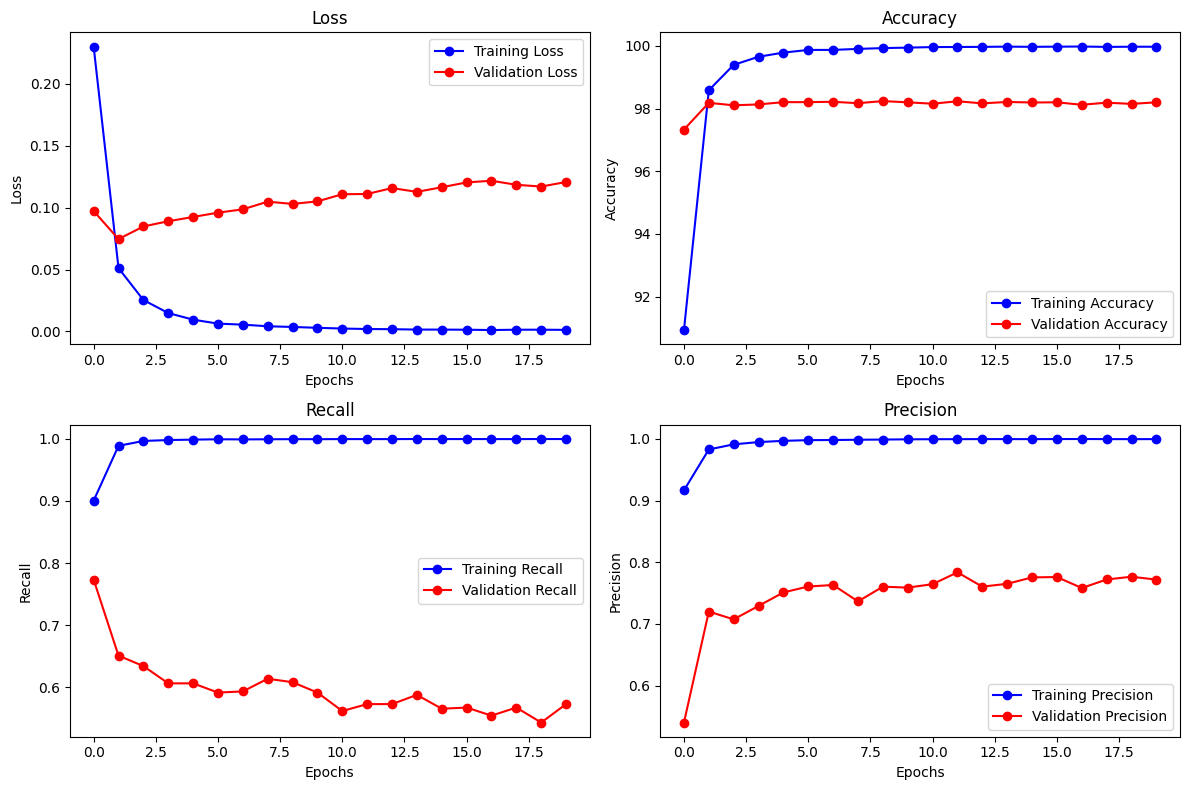

resnet50_eu_eik
Best F2 Score: 0.7118412046543465
Best Accuracy: 0.9733019238319591
Best Recall: 0.7732342007434945
Best Precision: 0.5402597402597402


In [3]:
def train_model(model, model_name, size):
    #for param in model.parameters(): param.requires_grad = False  # If feature extractor does not need to be updated

    #Change last output layer to 2 classes
    n_inputs = model.fc.in_features
    last_layer = nn.Linear(n_inputs, len(classes))
    model.fc = last_layer

    # cuda
    model = model.to(device)
    print(model)

    # Set the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Set the loss function
    criterion = nn.CrossEntropyLoss()
    # cuda
    criterion = criterion.to(device)

    # Learning curves
    results = {"training_acc": [], "training_loss": [], "validation_acc": [], "validation_loss": [], "training_recall": [], "validation_recall": [], "training_recall": [], "validation_recall": [], "training_precision": [], "validation_precision": []}

    # Loop over all epochs
    best_f2 = 0
    best_precision = 0
    best_recall = 0
    best_accuracy = 0
    best_model = []
    for e in range(epochs):
        # Debug
        print('Epoch {}/{}'.format(e+1, epochs))

        # Each epoch has a training and validation phase
        for phase in ['train','valid']:
            # Set the network state dependent on the phase
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # Reset the losses and corrects at the start of each epoch
            running_loss = 0.0
            running_corrects = 0.0
            tp = 0 #true positive
            fn = 0 #false negative
            fp = 0 #false positive
            
            # Extract batches from the data loaders untill all batches are retrieved
            num_samples = 0
            for inputs, labels in dataloaders_dict[phase]:

                # Inputs shape
                batch_size, c, h, w = inputs.shape

                # Store the inputs and labels to the selected device (cuda)
                inputs = inputs.to(device)  
                labels = labels.to(device)  

                # Forward pass through the network
                outputs = model(inputs)

                # Softmax transforms the output probabilities into one selected class
                _, class_pred = torch.max(outputs, 1)

                # Compute the loss of the batch
                loss = criterion(outputs, labels)
                
                # Update the losses and corrects for this batch
                running_loss += loss.item() * batch_size
                running_corrects += class_pred.eq(labels).sum().item()

                # Calculate total samples
                num_samples += batch_size

                # recall & precision calculation
                tp += ((class_pred == 1) & (labels == 1)).sum().item()
                fn += ((class_pred == 0) & (labels == 1)).sum().item()
                fp += ((class_pred == 1) & (labels == 0)).sum().item()

                # If in training phase, adapt the model paramters to account for the losses
                if phase=='train':
                    optimizer.zero_grad() # Pytorch keeps track of the gradients over multiple epochs, therefore initialise it to 0
                    loss.backward() # Calculate the weight gradients (Backward Propagation)
                    optimizer.step() # Update the model parameters using the defined optimizer 
                    

            # Save results
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            precision = tp / (tp + fp) if (tp + fp ) > 0 else 0     

            if phase == 'train':
                results['training_acc'].append((running_corrects/num_samples)*100)
                results['training_loss'].append(running_loss/num_samples)
                results['training_recall'].append(recall)
                results['training_precision'].append(precision)
                print("train_acc %.3f train_loss %.3f train_recall %.3f train_precision %.3f" % (running_corrects/num_samples, running_loss/num_samples, recall, precision))
            elif phase == 'valid':
                results['validation_acc'].append((running_corrects/num_samples)*100)
                results['validation_loss'].append(running_loss/num_samples)
                results['validation_recall'].append(recall)
                results['validation_precision'].append(precision)
                print("val_acc %.3f val_loss %.3f val_recall %.3f val_precision %.3f" % (running_corrects/num_samples, running_loss/num_samples, recall, precision))

            f2_score = 5*precision*recall/(4*precision + recall)
            # Deep copy the model, the F2 score is used since false negatives are more costly
            if phase=='valid' and f2_score > best_f2:
                print("F2 score: "+str(f2_score))
                print('-'*10)
                best_f2 = f2_score
                best_model = model
                best_recall = recall
                best_precision = precision
                best_accuracy = running_corrects/num_samples

    # Print
    print('Best val f2: {:.4f}'.format(best_f2))


    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Plot training and validation loss
    axs[0, 0].plot(range(len(results['training_loss'])), results['training_loss'], 'bo-', label='Training Loss')
    axs[0, 0].plot(range(len(results['validation_loss'])), results['validation_loss'], 'ro-', label='Validation Loss')
    axs[0, 0].set_title('Loss')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    # Plot training and validation accuracy
    axs[0, 1].plot(range(len(results['training_acc'])), results['training_acc'], 'bo-', label='Training Accuracy')
    axs[0, 1].plot(range(len(results['validation_acc'])), results['validation_acc'], 'ro-', label='Validation Accuracy')
    axs[0, 1].set_title('Accuracy')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].legend()

    # Plot training and validation recall
    axs[1, 0].plot(range(len(results['training_recall'])), results['training_recall'], 'bo-', label='Training Recall')
    axs[1, 0].plot(range(len(results['validation_recall'])), results['validation_recall'], 'ro-', label='Validation Recall')
    axs[1, 0].set_title('Recall')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Recall')
    axs[1, 0].legend()

    # Plot training and validation precision
    axs[1, 1].plot(range(len(results['training_precision'])), results['training_precision'], 'bo-', label='Training Precision')
    axs[1, 1].plot(range(len(results['validation_precision'])), results['validation_precision'], 'ro-', label='Validation Precision')
    axs[1, 1].set_title('Precision')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Precision')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

    return best_f2, best_accuracy, best_recall, best_precision, best_model,


fn_model = models.resnet50(pretrained=True)
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
best_f2, best_accuracy, best_recall, best_precision, best_model = train_model(fn_model, model_name, size)

print(model_name)
print("Best F2 Score:", best_f2)
print("Best Accuracy:", best_accuracy)
print("Best Recall:", best_recall)
print("Best Precision:", best_precision)

# save model
model_path = model_directory+'/'+model_name+'.pth'
os.makedirs(model_directory, exist_ok=True)
torch.save(best_model.state_dict(), model_path)


## Test evaluation
The model is applied in combination with a sliding window on the test dataset 

In [9]:
# Normalisation parameters
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]) 

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends torchvision.datasets.ImageFolder"""
    
    def __getitem__(self, index):
        # Call the original __getitem__
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # Get the image path
        path = self.imgs[index][0]
        # Extract the filename from the path
        filename = os.path.basename(path)
        # Add the filename to the original tuple
        tuple_with_filename = original_tuple + (filename,)
        return tuple_with_filename

data_dir = validate_test_directory + "/test"

# Define transformations
transformed_dataset = ImageFolderWithPaths(data_dir, transform=transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    normalize,
]))

dataloader = DataLoader(transformed_dataset, batch_size=1, shuffle=False)

In [10]:
# get main coco file with all windows and corresponding errors

f = open('../dataset/sahi_output/test/sahi_coco.json') 
data = json.load(f)

# category dict
cat_dict = {}
for i in data['categories']:
    cat_dict[i['id']] = i['name']


# fault dict
fault_dict = {}
for i in data['annotations']:
    fault_dict[i['image_id']] = cat_dict[i['category_id']]

# path dict
path_dict = {}
for i in data['images']:
    if i['id'] in fault_dict:
        path_dict[i['file_name']] = fault_dict[i['id']]


print(path_dict)

# create confusion matrix dict
confusion_matrix_dict = {}
for key, val in cat_dict.items():
     confusion_matrix_dict[val] = {"guess_bg": 0, "guess_fault": 0}
confusion_matrix_dict[classes[0]] = {"guess_bg": 0, "guess_fault": 0}    



def evaluate_model(model, test_loader, device):
    # Ensure model is in evaluation mode
    model.eval()

    # Initialize metrics
    running_corrects = 0
    tp = 0  # true positives
    fn = 0  # false negatives
    fp = 0  # false positives
    total_samples = 0

    # No gradient is needed for evaluation
    with torch.no_grad():
        for inputs, labels, filename in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Update metrics
            running_corrects += torch.sum(preds == labels).item()
            tp += ((preds == 1) & (labels == 1)).sum().item()
            fn += ((preds == 0) & (labels == 1)).sum().item()
            fp += ((preds == 1) & (labels == 0)).sum().item()
            total_samples += inputs.size(0)

            # Confusion matrix update, 1 = positive = faulty
            
            # input is background image
            if labels == 0:
                if preds == 1:
                    confusion_matrix_dict[classes[0]]["guess_fault"] += 1
                else:
                    confusion_matrix_dict[classes[0]]["guess_bg"] += 1

            # input is faulty image
            else:
                filename = filename[0]
                if filename in path_dict:
                    window_fault = path_dict[filename]
                    if preds == 1:
                        confusion_matrix_dict[window_fault]["guess_fault"] += 1
                    else:
                        confusion_matrix_dict[window_fault]["guess_bg"] += 1
                else:
                    print("error")

    # Calculate metrics
    accuracy = running_corrects / total_samples
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    return accuracy, recall, precision

# Assuming you have defined your test_loader and have the 'best_model' and 'device' from the previous training
accuracy, recall, precision = evaluate_model(best_model, dataloaders_dict['test'], device)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test Precision: {precision:.4f}")

{'PO22-34546_9_1_annotated_11129_0_11577_448.png': 'open fout', 'PO22-34546_9_1_annotated_11168_0_11616_448.png': 'open fout', 'PO22-34546_9_1_annotated_11129_718_11577_1166.png': 'open fout', 'PO22-34546_9_1_annotated_11168_718_11616_1166.png': 'open fout', 'PO22-34549_7_1_annotated_0_0_448_448.png': 'open fout', 'PO22-34549_7_1_annotated_3590_0_4038_448.png': 'open fout', 'PO22-34549_7_1_annotated_3949_0_4397_448.png': 'open fout', 'PO22-34549_7_1_annotated_4308_0_4756_448.png': 'open fout', 'PO22-34549_7_1_annotated_4667_0_5115_448.png': 'open fout', 'PO22-34549_7_1_annotated_5026_0_5474_448.png': 'open fout', 'PO22-34549_7_1_annotated_5385_0_5833_448.png': 'open fout', 'PO22-34549_7_1_annotated_6103_0_6551_448.png': 'open fout', 'PO22-34549_7_1_annotated_6462_0_6910_448.png': 'open fout', 'PO22-34549_7_1_annotated_6821_0_7269_448.png': 'open fout', 'PO22-34549_7_1_annotated_7180_0_7628_448.png': 'open fout', 'PO22-34549_7_1_annotated_7539_0_7987_448.png': 'open fout', 'PO22-34549_7

In [11]:
# Confusion matrix

# Initialize the confusion matrix
data = confusion_matrix_dict
categories = list(data.keys())
confusion_matrix = []

# Populate the confusion matrix
for category in categories:
    row = [data[category]["guess_bg"], data[category]["guess_fault"]]
    confusion_matrix.append(row)

# Print the confusion matrix
print(f"{'':>12} {'Background':>10} {'Fault':>5}")
for i, category in enumerate(categories):
    print(f"{category:>12}: {confusion_matrix[i][0]:>10} {confusion_matrix[i][1]:>5}")

             Background Fault
   open fout:         25   124
   open voeg:          5    16
        deuk:          1    14
        zaag:         50    79
       barst:         10    10
   open knop:          9     3
    snijfout:          8     3
veneer piece:          2     7
        vlek:         30     2
    ongekend:          2     0
        kras:         14    17
          bg:      16076    74


## Cut-out Method

This section describes the generation process for the cut-out method. In this approach, faults are isolated from the original input images. The same training code as mentioned previously should then be used for further processing.


In [ ]:
# Directory paths
main_directory = "cutout_folders"
cutout_directory = main_directory + "/cutout"
train = "train"
validate = "validate"
test = "test"
dataset = main_directory + "/dataset"

# Create dataset & cutout folders for each class
for i in classes:
    for y in [train, test, validate]:
        os.makedirs(dataset + "/" + y + "/" + i, exist_ok=True)
        os.makedirs(cutout_directory + "/" + y + "/" + i, exist_ok=True)

# Create a dictionary to map category IDs to category names
category_dict = {}
for cat in coco_data['categories']:
    id = cat['id']
    name = cat['name']
    category_dict[id] = name.replace(" ", "_")
print(category_dict)    

# Minimum dimension for images
min_dim = size

# Dictionary to store the fault category for each isolated fault in an image
image_fault_dic = {}

# Loop over all images in the dataset
for image in tqdm(coco_data['images'], desc='Processing images'):
    # Get the file name and its name without extension
    filename = image['file_name']
    filename_without_extension = filename.replace(".jpg", "")

    # Load the image
    file = cv2.imread(dataset_directory + "/" + filename)
    height, width = file.shape[:2]

    # Initialize exclusion zones list
    exclusion_zones = []

    if True:
        # Get annotations for the current image
        bbox_array = []
        fault_array = []
        for annotation in coco_data['annotations']:
            if image['id'] == annotation['image_id']:
                bbox_array.append(annotation['bbox'])
                fault_array.append(category_dict[annotation['category_id']])

        # Cut out faults (bounding boxes) with adjusted dimensions
        for index, bbox in enumerate(bbox_array):
            x, y, w, h = bbox
            x, y, w, h = int(x), int(y), int(w), int(h)

            # Calculate the required extra width and height to meet the minimum dimensions
            extra_width = max(0, min_dim - w)
            extra_height = max(0, min_dim - h)

            extra_left = extra_width // 2
            extra_right = extra_width - extra_left
            extra_above = extra_height // 2
            extra_below = extra_height - extra_above

            # Add padding and adjust bounding box so it doesn't go beyond image boundaries
            x_start = max(0, x - extra_left)
            y_start = max(0, y - extra_above)
            x_end = min(width, x + w + extra_right)
            y_end = min(height, y + h + extra_below)

            # Further adjust if still below minimum width or height
            if (x_end - x_start) < min_dim:
                if x_end == width:  # If we hit the right edge, add more to the left
                    x_start = max(0, x_end - min_dim)
                else:  # If we hit the left edge, add more to the right
                    x_end = min(width, x_start + min_dim)

            if (y_end - y_start) < min_dim:
                if y_end == height:  # If we hit the bottom edge, add more to the top
                    y_start = max(0, y_end - min_dim)
                else:  # If we hit the top edge, add more to the bottom
                    y_end = min(height, y_start + min_dim)

            exclusion_zones.append((x_start, y_start, x_end, y_end))

            # Get the fault name
            fault_name = fault_array[index]

            if fault_name in keepers:
                # Create a new file name for the cropped image
                new_file_name = f"{filename_without_extension}_window_{x}_{y}_{fault_name}"

                # Add to the image_fault_dic
                image_fault_dic[new_file_name] = fault_name

                # Crop the image and save it
                cropped_image = file[y_start:y_end, x_start:x_end]
                save_path = f"{cutout_directory}/{split_dict[filename]}/{classes[1]}/{new_file_name}.jpg"
                cv2.imwrite(save_path, cropped_image)
            
        # Apply black pixels to the exclusion zones in the original image
        for zone in exclusion_zones:
            x_start, y_start, x_end, y_end = zone
            file[y_start:y_end, x_start:x_end] = 0  # Set the pixels in the zone to black

    # Save the modified original image
    save_path = f"{cutout_directory}/{split_dict[filename]}/{classes[0]}/{filename_without_extension}.jpg"
    cv2.imwrite(save_path, file)